**Authors:**
Jonas Juhler-Nøttrup (S164217), Niels Asp Fuglsang (S164181), Morten Wehlast Jørgensen (S147056), Jens Thuren Lindahl (S124347)

## 42186 Model-based Machine Learning - Bayesian Spatial Count

The data set consists of 7 features
 - `census_tract` ID for the census/region. Nominal, integer.
 - `ped_nnjury_5to18` Number of injuries for pedestrians aged 5-18 in the years 2005-2014. Ratio, integer.
 - `youth_pop_5to18` Population of youths aged aged 5-18 within the census/region in 2010. Ratio, integer.
 - `commute_priv_vehicle` Percentage commuters who traveled to work primarily by a private vehicle, from the American Community Survey for the years 2010-2014. Ration, continuous.
 - `med_hhincome` Median household income from American Community Survey for the years 2010-2014. Interval, integer.
 - `avg_ann_daily_traffic` Maximum value of street-level annual average daily traffic values for that census tract from 2015. Interval, integer.
 - `fragment_nndex` A combined metric consisting of standardized data describing; estimates of vacant housing units, householders living alone, non-owner occupied housing units and population having moved within the previous year. Interval, continuous.
 
 
The project will treat `ped_nnjury_5to18` as the dependent variable $y$. 

**Research topic:** How may we model non-linear dependencies on the inputs $\textbf{X}_n$?

More specifically, we wish to determine the advantages and disadvantages of the following approaches:
- Neural network 
- Hierarchical modelling

For each area $n$ in data set, we observe a count of injuries, $y_n$. 
The normal apprach is to assume linear dependence such that
$$
y_n \sim \text{NB}(r, p_n) \\
p_n= \frac{1}{1+\exp(-\psi_n)} \\
\psi_n = \beta^T\textbf{X}_n+\phi_n
$$

Where $\textbf{X}_n$ are the characteristics of the area and $\phi_n$ is a correlated error term with mean 0 and standard deviation $\sigma$.

### Load packages data

In [1]:
import random
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import torch
from torch import nn, Tensor
import torch.optim as optim
from sklearn import linear_model
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam

from src.utils import load_data

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Set random seed (for reproducability)
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
pyro.set_rng_seed(0)

### Load and standardize data

In [4]:
# Load data and split into train and test
X, y, k, county_map, feat_names = load_data(impute=True)
X_train, X_test = X
y_train, y_test = y
k_train, k_test = k
print('Training data:\nX-shape: {}, y-shape: {}'.format(X_train.shape, y_train.shape))
print('\nTest data:\nX-shape: {}, y-shape: {}'.format(X_test.shape, y_test.shape))

Training data:
X-shape: (1676, 38), y-shape: (1676,)

Test data:
X-shape: (419, 38), y-shape: (419,)


In [5]:
# Standardize input features only using X_train
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

## Baseline model

In order to have a baseline for comparison, we produce a standard linear regression on the data.<br>
This will serve as a benchmark for evaluating how well the more complex models aid in predicting the number of accidents for  youths.

In [6]:
# Create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)

# Make predictions for test set
y_hat_lreg = lreg.predict(X_test)
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# Evaluate prediction accuracy
print("Baseline MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [ 3.30027249  7.4228757   4.50567392 14.34175354 15.8096688 ]
first 5 true values: [ 0  9  3 15 23]
Baseline MSE: 41.603160892479394


As we have a large number of variables in the model, we investigate whether all variables are significant.

In [7]:
# Fit Ordinary Least Squares (OLS) model to the data.
X2 = sm.add_constant(X_train)
ols = sm.OLS(y_train, X2)
ols = ols.fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     21.92
Date:                Thu, 27 May 2021   Prob (F-statistic):          2.94e-116
Time:                        13:55:29   Log-Likelihood:                -5376.6
No. Observations:                1676   AIC:                         1.083e+04
Df Residuals:                    1638   BIC:                         1.104e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2542      0.148     55.827      0.0

So only a very few number of parameters are significant. The model is heavily driven by bias and x1.<br>
Let's try only keeping 8 features based on Least Angle Regression Selection (LARS):

In [8]:
# Get the 8 most significant features with Least Angle Regression
lars = linear_model.Lars(n_nonzero_coefs=8)
lars.fit(X_train, y_train)
linear_ids = lars.coef_ != 0
linear_ids = np.array([i for i, incl in enumerate(linear_ids) if incl])
print("Features to be included:")
print("-"*20)
for idx in linear_ids:
    print(feat_names[idx])

Features to be included:
--------------------
youth_pop_5to18
commute_priv_vehicle
med_hhincome
White
Black
Poverty
Service
Transit


In [9]:
# Fit new model with 8 most significant features
X2 = sm.add_constant(X_train[:, linear_ids])
ols2 = sm.OLS(y_train, X2)
ols2 = ols2.fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     96.25
Date:                Thu, 27 May 2021   Prob (F-statistic):          1.07e-131
Time:                        13:55:30   Log-Likelihood:                -5395.4
No. Observations:                1676   AIC:                         1.081e+04
Df Residuals:                    1667   BIC:                         1.086e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2542      0.148     55.692      0.0

Notice that all variables might not still be significant, but this might change based on the train/test split. On could also use forward or backward feature selection for this matter.

In [10]:
# Create and fit regression model only using chosen features
lreg = linear_model.LinearRegression()
lreg.fit(X_train[:, linear_ids], y_train)

# Make predictions for test set
y_hat_lreg = lreg.predict(X_test[:, linear_ids])
print("First 5 predictions:", y_hat_lreg[:5])
print("First 5 true values:", y_test[:5])

# Evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

First 5 predictions: [ 5.20248878  6.68793155  4.45549343 14.572102   15.24162092]
First 5 true values: [ 0  9  3 15 23]
MSE: 41.434559241549906


A small improvement, but nothing impressive.

## Hierarchical model

In the hierarchical model, we seek to investigate whether some groups within the data may be more prone to accidents than others. By doing so, we hope to uncover certain findings in our data which allow us to get a better insight into the underlying patterns. Within our dataset we have the feature `County`, and we therefore choose to let our groups be defined by the counties. In total there are 5, distributed in the data as follows:

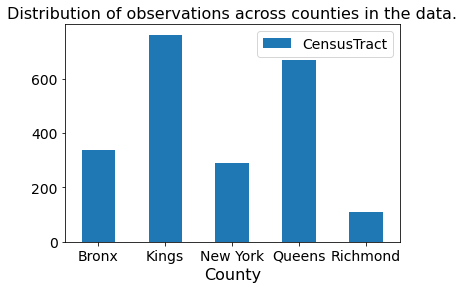

In [11]:
# Visualize number of observations for each county
df_census = pd.read_csv("data/nyc_census_tracts.csv")
fig, ax = plt.subplots(1,1)
df_census.groupby("County").count().plot.bar(y="CensusTract", ax=ax, rot=0)
plt.title("Distribution of observations across counties in the data.")
plt.show()

### Defining the model

The model will be based on the following PGM and generative process:

#### PGM
<img src="./assets/hierarchical1.PNG" alt="hej" width="250"/>

#### Generative Process - Hierarchical model

<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma \sim \text{HalfCauchy}(\gamma)$. </li>
    <li> For each group $k \in \{1, \dots, K\}$ </li>
    <ol>
        <li> Draw linear coefficients $\boldsymbol{\beta_k} \sim N(\boldsymbol{\beta}_k|\boldsymbol{\mu}_\beta,\sigma_\beta^2\textbf{I})$</li>
    </ol>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \boldsymbol{\beta}_{k_n}^T\boldsymbol{X}_n, \sigma^2)$</li>
        <li> Compute $p_n = 1 / (1 + e^{-\psi_n}$)</li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

In [12]:
def hierarchical_model(X, k, n_k, obs=None, pred=False):
    
    # Number of observations and features
    N, n_feat = X.shape
    
    # Priors for distributions
    r_gamma1 = 5
    r_gamma2 = 2
    sigma_gamma = 1
    mu_beta = 0
    sigma_beta = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2))
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma))
    
    
    with pyro.plate("group", n_k):
        # Draw linear coefficient parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(mu_beta*torch.ones(n_feat), sigma_beta*torch.ones(n_feat)).to_event()
        )
        
    with pyro.plate("observations", N):
        # Compute mean for psi-distribution with linear model
        psi_mu = torch.sum(X * beta[k], axis=1)
        
        # Sample psi (if-statement avoids use of posterior psi when predicting)
        if pred:
            psi = dist.Normal(psi_mu, sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
        
        # Sample prediction from negative binomial
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [13]:
# Prepare data for Pyro model by converting to tensors 
if not torch.is_tensor(X_train):
    X_train = torch.tensor(X_train).float()
    X_test  = torch.tensor(X_test).float()
    y_train = torch.tensor(y_train).float()
    k_train = torch.tensor(k_train).long() # these are indices, therefore they need to be (long) integers
    
# Add intercept
X_train = torch.cat((torch.ones(X_train.shape[0], 1), X_train), dim=-1)
X_test = torch.cat((torch.ones(X_test.shape[0], 1), X_test), dim=-1)    

# Get number of counties
n_k = len(np.unique(np.concatenate(k)))

# We must shift linear ids by 1 to account for intercept
linear_ids = [0, *(linear_ids + 1)]

In [14]:
%%time

# Define guide function.
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 2000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=1)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train[:, linear_ids], k_train, n_k, y_train)
    
    # Display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh()

2000 ELBO: 5074.1: 100%|██████████| 2000/2000 [00:17<00:00, 115.90it/s]


CPU times: user 1min 38s, sys: 3.62 s, total: 1min 41s
Wall time: 17.3 s


### Visualizations of variable differences from county to county
We may now investigate how the intercept estimates differ across counties, to determine if any county is more dangerous than others.

In [15]:
from pyro.infer import Predictive
predictive = Predictive(hierarchical_model, guide=guide, num_samples=5000,
                        return_sites=("beta", "r", "pred", "sigma"))
samples = predictive(X_train[:, linear_ids], k_train, n_k, y_train)

# Predict for X_test by passing through the model using the posterior
preds = predictive(X_test[:, linear_ids], k_test, n_k, pred=True)

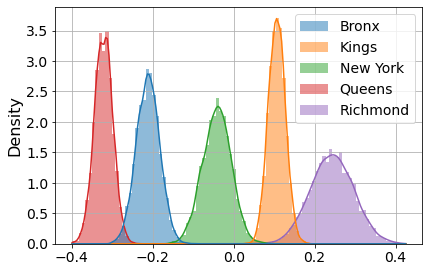

In [16]:
# Visualize intercept coefficient distribution for each county
fig = plt.figure()

beta_samples = samples["beta"].detach().numpy()
beta_index = 0
df = pd.DataFrame(beta_samples[:,:,beta_index])
df.columns = [county_map[c] for c in range(len(df.columns))]
sns.histplot(df, multiple="stack", stat="density", bins=100, kde=True, edgecolor="none")
#plt.title(f"Distribution of beta0  (Intercept)")

plt.grid(True)
fig.tight_layout()
fig.savefig('assets/dist_beta0_hier.pdf', format="pdf")
plt.show()

The plot show us that Kings and Richmond have a positive intercept while the others have negative. This could indicate that these counties might have a higher base number of accidents happen.

### Predict with the model
We produce three estimates for the MSE; using the mean, the median and lastly by taking the mean of samples from the generative process.

In [17]:
# Extract beta and r samples from posteriors
beta_samples = samples["beta"].detach().numpy()
r_samples = samples["r"].detach().numpy()

# Predict by computing the mean of parameters and passing through NB dist
beta = beta_samples.mean(axis=0)
r = r_samples.mean(axis=0)
psi = np.sum(beta[k_test] * X_test[:, linear_ids].numpy(), axis=1)
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean) # Extract mean from NB dist and use as prediction
print("MSE   (mean posterior):", sum((y_hat - y_test)**2)/len(y_hat))

# Predict by computing the median
beta = np.median(beta_samples, axis=0)
r = np.median(r_samples, axis=0)
psi = np.sum(beta[k_test] * X_test[:, linear_ids].numpy(), axis=1)
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
print("MSE (median posterior):", sum((y_hat - y_test)**2)/len(y_test))

# Predictions obtained by sampling from the NB dist.
y_hat = preds["pred"].detach().numpy().mean(axis=0)
print("MSE (generative process):", sum((y_hat - y_test)**2)/len(y_test))

MSE   (mean posterior): 42.21093986636309
MSE (median posterior): 42.204028168536205
MSE (generative process): 42.03955975139622


In this case we see that using the estimate produced by the generative process achieves the smallest MSE. Still, the model does not perform better than the linear regression. The model predictions are visualized below.

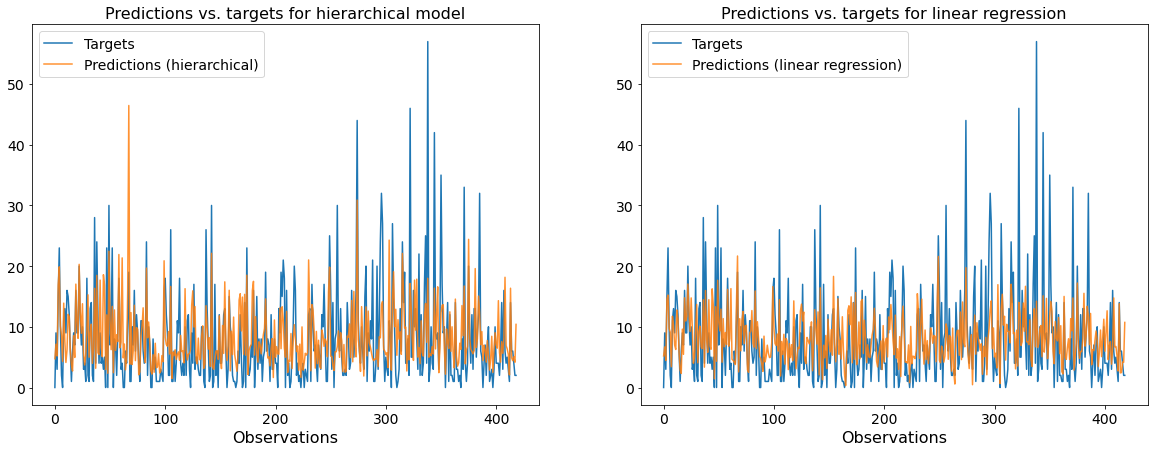

In [18]:
# Visualize predictions from the hierarchical model and linear regression
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (hierarchical)", alpha=0.85)
ax[0].legend()
ax[0].set_xlabel("Observations")
ax[0].set_title("Predictions vs. targets for hierarchical model")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)", alpha=0.85)
ax[1].legend()
ax[1].set_xlabel("Observations")
ax[1].set_title("Predictions vs. targets for linear regression")
plt.show()

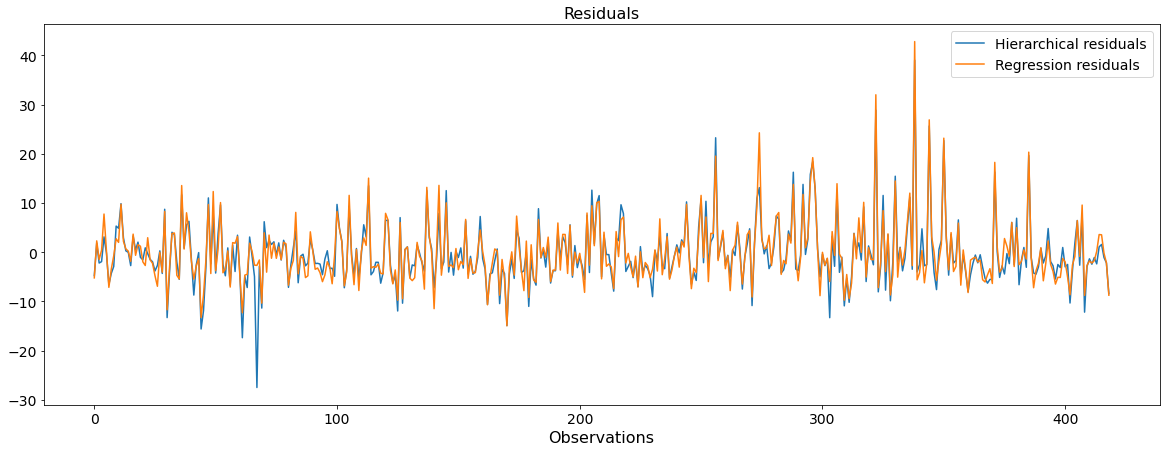

In [19]:
# Visualize residuals for both models
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="Hierarchical residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals")
ax.legend()
ax.set_xlabel("Observations")
plt.title("Residuals")
plt.show()

## Extending the hierarchical model to include non-linearity (combined model)

Let $\textbf{X}_n$ denote the characteristics of the n'th area. We now instead assume that the relationship between $\textbf{X}_n$ and $y_n$ can be expressed through a non-linear mapping $f_{nnet}$, where for $m$ features we have the mapping
$$
f_{nnet}: \mathbb{R}^m \mapsto \mathbb{R},
$$

During the lectures, it was proposed to split the features up into two sets of features $\textbf{X}_n'$ and $\textbf{X}_n^*$ such that $\textbf{X}_n' \bigcup \textbf{X}_n^* = \textbf{X}_n$ and $\textbf{X}_n' \bigcap \textbf{X}_n^* = \emptyset$.
One set of features, $\textbf{X}_n'$, would then model a linear relationship between the variables, while the other, $\textbf{X}_n^*$, would undergo a non-linear transformation through a neural net, yielding

$$
\psi_n = \beta^T\textbf{X}_n' + f_{\text{nnet}}(\textbf{X}^*_n)+\phi_n.
$$

We select a subset of features $\textbf{X}' \subseteq \textbf{X}$ which will be modelled using the hierarchical parameter vector $\beta_k$ and the complement of the set $\textbf{X} \backslash \textbf{X}' = \textbf{X}^*$ which will then go into the neural network. This gives us the following PGM and generative process

#### PGM
<img src="./assets/hierarchical2.PNG" width="250">

#### Generative Process - Hierarchical model + neural network
<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma \sim \text{HalfCauchy}(\gamma)$. </li>
    <li> Draw coefficients for neural net $\boldsymbol{\theta} \sim N(\boldsymbol{\theta}|\textbf{0},\tau \textbf{I})$</li>
    <li> For each group $k \in \{1, \dots, K\}$ </li>
    <ol>
        <li> Draw linear coefficients $\boldsymbol{\beta}_k \sim N(\boldsymbol{\beta}_k|\boldsymbol{\mu}_\beta,\sigma_\beta \textbf{I})$</li>
    </ol>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \boldsymbol{\beta}_{k_n}^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n), \sigma^2)$</li>
        <li> Compute $p_n = 1 / (1 + e^{-\psi_n}$)</li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

#### Splitting up the features

In order to determine which features go into $\textbf{X}'$ and which go into $\textbf{X}^*$, we will use the features selected by the LARS-algorithm in the hierarchical part of the model, and the remainder in the neural net.

In [20]:
def hierarchical_nn_model(X, linear_ids, k, n_k, obs=None, pred=False):
    # Split X into prime and star
    X_lin = X[:, linear_ids]
    X_nonlin = X[:, [i for i in range(X.shape[1]) if i not in linear_ids]]
    
    # Number of observations
    N, lin_feat = X_lin.shape
    nonlin_feat = X_nonlin.shape[1]
    
    
    # Prior parameters
    r_gamma1 = 5
    r_gamma2 = 2
    sigma_gamma = 1
    tau = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma).to_event())
    
    # Draw parameters for artificial neural network with 2 hidden layers
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(nonlin_feat, 8),tau*torch.ones(nonlin_feat, 8)).to_event()) # input to hidden
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(8), torch.ones(8)).to_event()) # bias
    w2 = pyro.sample("w2", dist.Normal(torch.zeros(8, 4), tau*torch.ones(8, 4)).to_event()) # hidden to hidden 
    b2 = pyro.sample("b2", dist.Normal(torch.zeros(4), torch.ones(4)).to_event()) # bias
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(4, 1), tau*torch.ones(4, 1)).to_event()) # hidden to output
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(1), torch.ones(1)).to_event()) # bias
    
    with pyro.plate("group", n_k):
        # Draw linear coefficient parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(torch.zeros(lin_feat), torch.ones(lin_feat)).to_event()
        )
    
    with pyro.plate("data", N):
        # NN forward pass
        x_nn = torch.relu(torch.matmul(X_nonlin, w1) + b1)
        x_nn = torch.relu(torch.matmul(x_nn, w2) + b2)
        x_nn = torch.matmul(x_nn, w3) + b3

        # Combine linear model and neural network (non linear)
        lin_contr = torch.sum(X_lin * beta[k], axis=1)
        psi_mu = lin_contr + x_nn.reshape(-1)
        
        if pred:
            psi = dist.Normal(psi_mu, sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
            
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [21]:
%%time

# Define guide function.
nn_guide = AutoDiagonalNormal(hierarchical_nn_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 2000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=3)
svi = SVI(hierarchical_nn_model, nn_guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, linear_ids, k_train, n_k, y_train)
    
    # Display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh()

2000 ELBO: 5132.7: 100%|██████████| 2000/2000 [01:01<00:00, 32.36it/s]

CPU times: user 5min 58s, sys: 7.34 s, total: 6min 6s
Wall time: 1min 1s


#### Predict with the model

In [22]:
# Collect samples from model in order to visualize parameters
predictive = Predictive(hierarchical_nn_model, guide=nn_guide, num_samples=5000,
                        return_sites=())
samples = predictive(X_train, linear_ids, k_train, n_k)

# Predict for X_test by passing through the model using the posterior
preds = predictive(X_test, linear_ids, k_test, n_k, pred=True)

In [23]:
# Extract beta, r and nn parameter samples from posteriors
beta = samples["beta"].detach().numpy().mean(axis=0)
r = samples["r"].detach().numpy().mean(axis=0)
w1 = samples["w1"].mean(axis=0)
b1 = samples["b1"].mean(axis=0)
w2 = samples["w2"].mean(axis=0)
b2 = samples["b2"].mean(axis=0)
w3 = samples["w3"].mean(axis=0)
b3 = samples["b3"].mean(axis=0)

# Predict by computing the mean of parameters and passing through NB dist
# NN forward pass
X_test_nonlin = X_test[:, [i for i in range(X_test.shape[1]) if i not in linear_ids]]
x_test_nn = torch.matmul(torch.relu(torch.matmul(torch.relu(torch.matmul(X_test_nonlin, w1) + b1), w2) + b2), w3) + b3

# Propagate through rest of model
psi = np.sum(beta[k_test] * X_test.numpy()[:, linear_ids], axis=1) + x_test_nn.detach().numpy().ravel()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# Evaluate prediction accuracy
print("MSE (mean):", sum((y_hat - y_test)**2)/len(y_hat))

# Predict by computing the median
beta = np.median(samples["beta"].detach().numpy(), axis=0)
r = np.median(samples["r"].detach().numpy(), axis=0)
psi = np.sum(beta[k_test] * X_test.numpy()[:, linear_ids], axis=1) + x_test_nn.detach().numpy().ravel()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# Evaluate prediction accuracy
print("MSE (median):", sum((y_hat - y_test)**2)/len(y_hat))

# Predictions obtained by sampling from the NB dist.
y_hat = preds["pred"].detach().numpy().mean(axis=0)
print("MSE (NB sampling):", sum((y_hat - y_test)**2)/len(y_test))


MSE (mean): 41.80146739814836
MSE (median): 41.80223837983204
MSE (NB sampling): 40.778425793466134


This time we finally end up beating the linear regression! On top of that, the model has maintained its interpretability through the hierarchical modelling aspect.

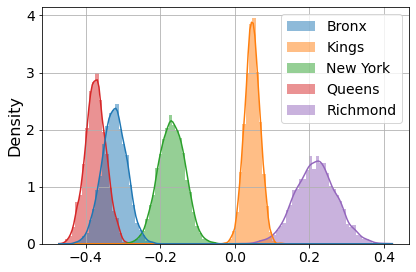

In [24]:
# Visualize intercept coefficient distribution for each county
fig = plt.figure()

beta_samples = samples["beta"].detach().numpy()
beta_index = 0
df = pd.DataFrame(beta_samples[:,:,beta_index])
df.columns = [county_map[c] for c in range(len(df.columns))]
sns.histplot(df, multiple="stack", stat="density", bins=100, kde=True, edgecolor="none")
#plt.title(f"Distribution of beta0  (Intercept)")

plt.grid(True)
fig.tight_layout()
fig.savefig('assets/dist_beta0_combined.pdf', format="pdf")
plt.show()

Kings and Richmond still have positive intercepts, however the model has now reduced the intercept vastly for Kings, while Richmond is more or less unchanged.

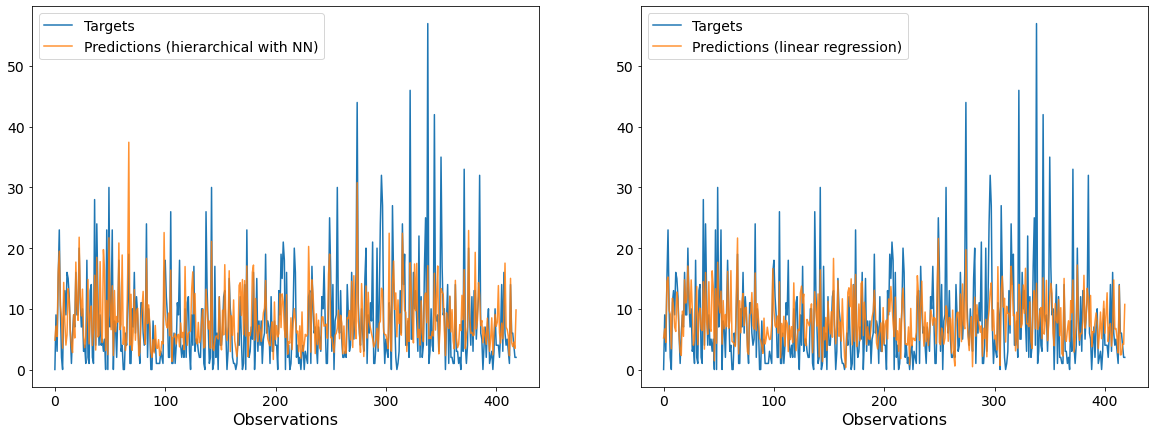

In [25]:
# Visualize predictions from the combined model and linear regression
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (hierarchical with NN)", alpha=0.85)
ax[0].legend()
ax[0].set_xlabel("Observations")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)", alpha=0.85)
ax[1].legend()
ax[1].set_xlabel("Observations")
plt.show()

[]

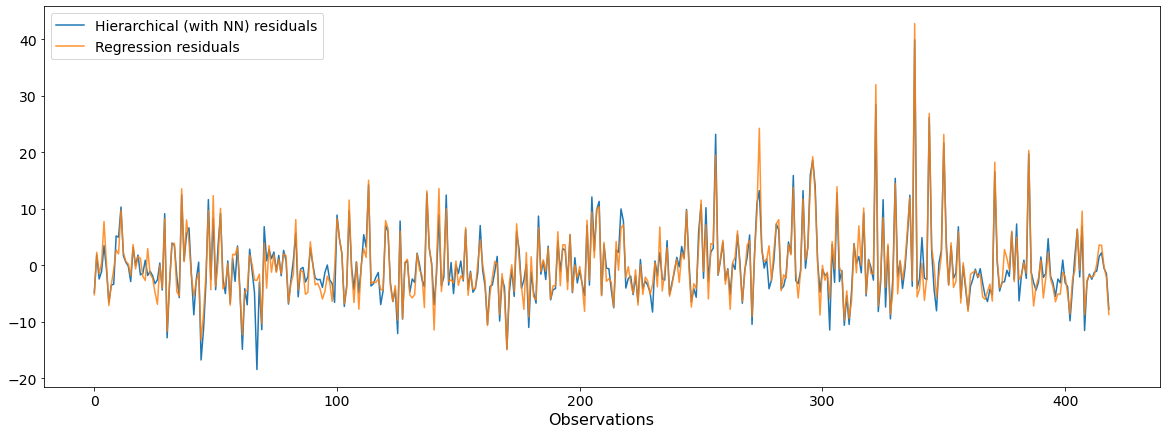

In [26]:
# Visualize residuals for both models
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="Hierarchical (with NN) residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals", alpha=0.85)
ax.legend()
ax.set_xlabel("Observations")
plt.plot()

## Pure neural network model

Adding the neural network to the hierarchical model had a positive effect on the results, which indicates that there might be some non-linear dependencies in the data. A natural question to ask is whether the performance would be even higher if all features $\boldsymbol{X}_n$ were passed through a neural network. <br>
Since a neural net is a universal function approximator (Bishop, p.230), it should discover and be able to model any linear dependecies as well as non-linear, allowing us to simply apply the neural net to all of the features such that we may instead compute $\psi_n$ as

$$
\psi_n = f_{\text{nnet}}(\textbf{X}_n)+\phi_n.
$$

The following structure for the neural network was found to be the best through a series of tests on the training data:

| Layer | Number of neurons | Activation function |
|:-----:|:-----------------:|:-------------------:|
| Input |         35        |          -          |
|   1   |         8         |         ReLU        |
|   2   |         4         |         ReLU        |
| Output|         1         |        Linear       |


Notice: In the implementation, we found the Predictive() class of Pyro to not always behave as expected when introducing a PyTorch neural network, so we decided to code it by hand.

#### PGM
<img src="./assets/NN_PGM.PNG" width=250>


**Generative Process - Neural network**

<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma \sim \text{HalfCauchy}(\gamma)$ . </li>
    <li> Draw coefficients for neural net $\boldsymbol{\theta} \sim N(\boldsymbol{\theta}|\textbf{0},\tau \textbf{I})$</li>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n|f_{\text{nnet}}(\textbf{X}_n),\sigma^2)$ </li>
        <li> Compute $p_n = 1 / (1 + e^{-\psi_n}$)</li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

In [27]:
def nn_model(X, obs=None, pred=False):
    # Number of observations
    N, n_feat = X.shape
    
    # Hyperparameters
    r_gamma1 = 5
    r_gamma2 = 2
    sigma_gamma = 1
    tau = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma).to_event())
    
    # Artificial neural network parameters
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(n_feat, 8), tau*torch.ones(n_feat, 8)).to_event())
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(8), tau*torch.ones(8)).to_event())
    w2 = pyro.sample("w2", dist.Normal(torch.zeros(8, 4), tau*torch.ones(8, 4)).to_event())
    b2 = pyro.sample("b2", dist.Normal(torch.zeros(4), tau*torch.ones(4)).to_event())
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(4, 1), tau*torch.ones(4, 1)).to_event())
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(1), tau*torch.ones(1)).to_event())
    
    with pyro.plate("data", N):
        # Manual forward pass in neural network
        x_nn = torch.relu(torch.matmul(X, w1) + b1)
        x_nn = torch.relu(torch.matmul(x_nn, w2) + b2)
        psi_mu = torch.matmul(x_nn, w3) + b3

        # Sample psi. If statement ensures that posterior is not used during prediction
        if pred:
            psi = dist.Normal(psi_mu.squeeze(), sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu.squeeze(), sigma))
        
        # Draw observation from negative binomial
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [28]:
%%time

# Define guide function.
nn_guide = AutoDiagonalNormal(nn_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 1000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=3)
svi = SVI(nn_model, nn_guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps), position=0)
for step in t:
    elbo = svi.step(X_train, y_train)
    
    # Display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh()

1000 ELBO: 5129.5: 100%|██████████| 1000/1000 [00:25<00:00, 39.39it/s]

CPU times: user 2min 28s, sys: 2.74 s, total: 2min 31s
Wall time: 25.4 s


In [29]:
# Extract samples from posterior distributions
predictive = Predictive(nn_model, guide=nn_guide, num_samples=5000)
samples = predictive(X_train, y_train)

# Predict for X_test by passing through the model using the posterior
preds = predictive(X_test, pred=True)

### Predict with the model

In [30]:
# Compute prediction using generative process
y_hat = preds["pred"].detach().numpy().mean(axis=0)
print("MSE (generative process):", sum((y_hat - y_test)**2)/len(y_hat))

MSE (generative process): 41.730964974361825


#### Comparing linear regression and the neural network

Through the predictions found using the posterior distribution, we find $MSE_{nnet} > MSE_{lreg}$, even though just slightly larger.<br>
In the plots below, we compare the predictions as well as the residuals for the two models.<br>
The plots show that the neural net has not managed to find any signal that the regression model had missed.
In fact, the predictions of the two models look very similar.

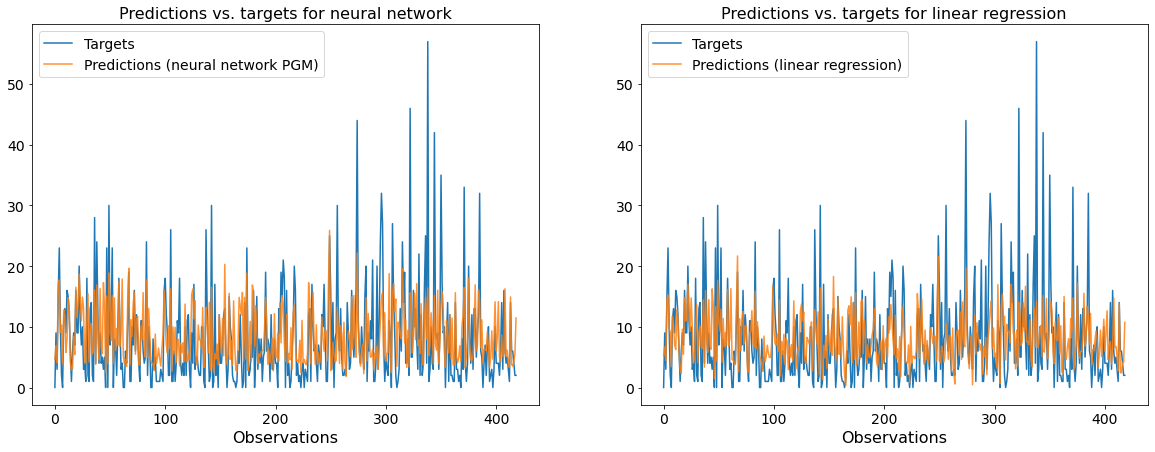

In [31]:
# Visualize predictions from the neural network model and linear regression
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (neural network PGM)", alpha=0.85)
ax[0].legend()
ax[0].set_xlabel("Observations")
ax[0].set_title("Predictions vs. targets for neural network")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)", alpha=0.85)
ax[1].legend()
ax[1].set_xlabel("Observations")
ax[1].set_title("Predictions vs. targets for linear regression")
plt.show()

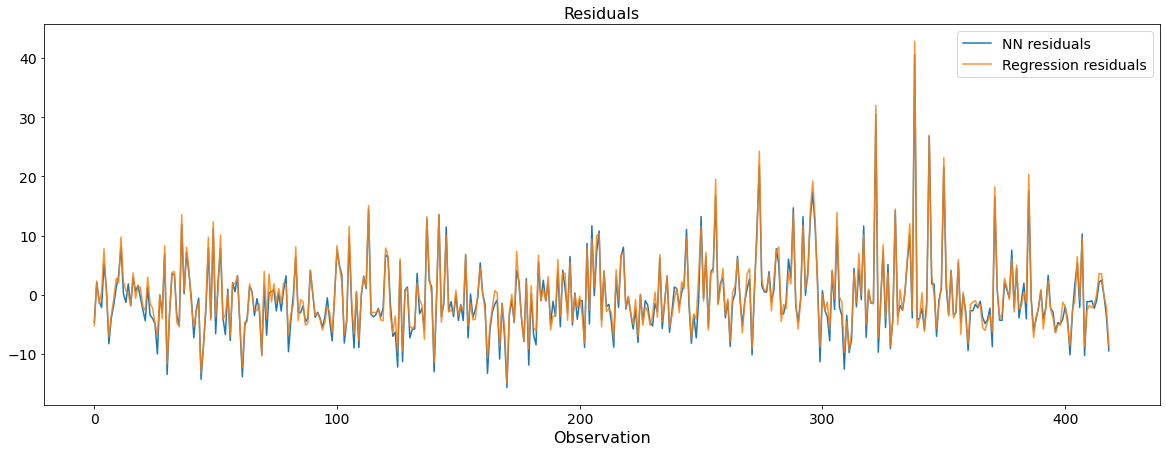

In [32]:
# Visualize residuals for both models
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="NN residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals", alpha=0.85)
ax.legend()
ax.set_xlabel("Observation")
plt.title("Residuals")
plt.show()

### Autoencoder

We see that only one of the models produced manage to beat the baseline model. As feature selection is an art in itself, we now seek to reduce the dimensionality of our data by searching for some latent representation of the variables that may provide us with fewer variables and hopefully less noise.<br>
In doing so, we first develop an Autoencoder to encode the data and reduce the dimensionality. Let $h$ denote a mapping produced by the autoencoder from our feature space of dimension $m$ to the outspace of the encoded data, with dimensionality $p < m$,
$$
f_{ae}: \mathbb{R}^m \mapsto \mathbb{R}^p.
$$

We then try to estimate $\psi_n$ as

$$
\psi_n = \beta^T h(\textbf{X}_n) + \phi_n.
$$

This model gives rise to the following PGM

#### PGM
<img src="./assets/AE_PGM.PNG" width=250>

The parameter estimates are then obtained through the following generative process (notice that data may be encoded before running the sampling).

#### Generative Process - Autoencoder

<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma^2 \sim \text{HalfCauchy}(\gamma)$. </li>
    <li> Draw linear coefficients $\beta \sim N(\beta|\bf{\mu_\beta},\bf{\sigma_\beta}\textbf{I})$</li>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^Tf_{ae}(\textbf{X}_n), \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

#### Determining a suitable output space

Before we may encode the data, we must first find a suitable value for $p$. This is done by searching for a value of p where the data we first encode, and the decode, is as close to the original data as possible. We find that $p=18$ to be the best of the tested values, effectively cutting the number of variables in half for our final model.

Note: the training of the autoencoder is done in the file `autoencoder.ipynb`. Here we will simply import the pretrained model.

In [33]:
class Autoencoder(nn.Module):
    
    """An autoencoder"""
    
    
    def __init__(self, input_shape, latent_features):
        super(Autoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=24),
            nn.Tanh(),
            nn.Linear(in_features=24, out_features=latent_features)
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=24),
            nn.Tanh(),
            nn.Linear(in_features=24, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=self.observation_features)
        )        

    def forward(self, x):
        """Run encoder and decoder, and output latent space together with reconstruction."""
        
        # Latent space
        h = self.encoder(x)

        y = self.decoder(h)
        
        return h, y
    
    def encode(self, x):
        """Run encoder and decoder, and output latent space together with reconstruction."""
        
        # Latent space
        h = self.encoder(x)
        
        return h

In [34]:
# Dimensionality of latent space (hyperparameter)
latent_features = 18
ae = Autoencoder(X_train.shape[1], latent_features)
print(ae)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=39, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=24, bias=True)
    (3): Tanh()
    (4): Linear(in_features=24, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=24, bias=True)
    (1): Tanh()
    (2): Linear(in_features=24, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=39, bias=True)
  )
)


### Using the autoencoder in a model

In [35]:
def ae_model(X_latent, obs=None, pred=False):
    # Initialize the neural network from PyTorch
    N, n_latent = X_latent.shape

    beta_mu = 0
    beta_sigma = 1
    
    beta = pyro.sample(
            "beta",
            dist.Normal(beta_mu*torch.ones(n_latent), beta_sigma*torch.ones(n_latent)).to_event()
        )
    
    # Hyperparameters
    r_gamma1 = 5
    r_gamma2 = 2
    
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(1))


    # The generative process
    if beta.dim() > 1:
        beta = torch.reshape(beta, (n_latent,))
    
    with pyro.plate("data", N):
        psi_mu = torch.matmul(X_latent, beta)

        if pred:
            psi = dist.Normal(psi_mu, sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
            
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
        return pred
    return pred

In [36]:
import pickle

# Define guide function
guide = AutoDiagonalNormal(ae_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 1000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(ae_model, guide, optimizer, loss=elbo)

# Prepare data
if not torch.is_tensor(X_train) or not torch.is_tensor(X_test):
    X_train = torch.tensor(np.array(X_train)).float()
    X_test = torch.tensor(np.array(X_test)).float()
    y_train = torch.tensor(y_train).float()    

    
# Load pretrained autoencoder parameters
filename = 'config/autoencoder_v1.pkl'
ae = pickle.load(open(filename,'rb'))
ae.to('cpu')
    
# Encode data
with torch.no_grad():
    X_train_l = ae.encode(X_train[:, 1:])
    X_test_l = ae.encode(X_test[:, 1:])

# Add intercept
X_train_l = torch.cat((torch.ones(X_train_l.shape[0], 1), X_train_l), dim=-1)
X_test_l = torch.cat((torch.ones(X_test_l.shape[0], 1), X_test_l), dim=-1) 
    
    
# Do gradient steps
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train_l, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh() # to show immediately the update

1000 ELBO: 5080.9: 100%|██████████| 1000/1000 [00:08<00:00, 124.48it/s]


In [37]:
# Get posterior samples and pass the test data through the generative process
predictive = Predictive(
    ae_model,
    guide=guide,
    num_samples=5000,
    return_sites=("beta", "r", "pred")
)
samples = predictive(X_train_l, y_train)
preds = predictive(X_test_l, pred=True)

In [38]:
# Predictions
# Extract beta and r samples from posteriors
beta_samples = samples["beta"].detach().numpy()
r_samples = samples["r"].detach().numpy()

# Predict by computing the mean of parameters and passing through NB dist
beta = beta_samples.mean(axis=0)
r = r_samples.mean(axis=0)
psi = np.sum(beta * X_test_l.numpy(), axis=1)
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean) # Extract mean from NB dist and use as prediction
print("MSE   (mean posterior):", sum((y_hat - y_test)**2)/len(y_hat))

# Predict by computing the median
beta = np.median(beta_samples, axis=0)
r = np.median(r_samples, axis=0)
psi = np.sum(beta * X_test_l.numpy(), axis=1)
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat2 = np.array(d.mean)
print("MSE (median posterior):", sum((y_hat2 - y_test)**2)/len(y_test))

# Predictions obtained by sampling from the NB dist.
y_hat3 = preds["pred"].detach().numpy().mean(axis=0)
print("MSE (generative process):", sum((y_hat3 - y_test)**2)/len(y_test))

MSE   (mean posterior): 44.25971914237859
MSE (median posterior): 44.2687937000423
MSE (generative process): 43.3703590194861


The MSE shows us that working with a latent representation of the variables does not provide any advantage over the linear regression.

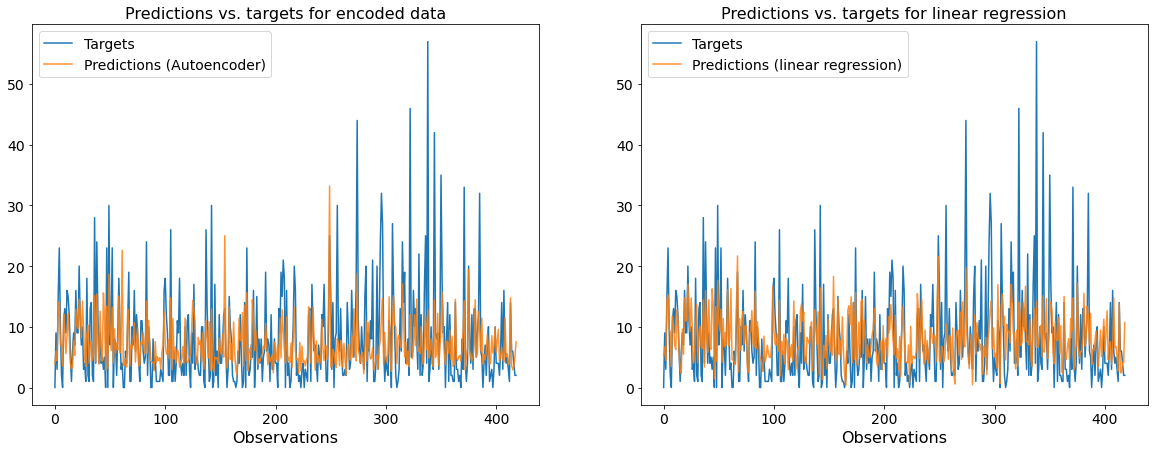

In [39]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (Autoencoder)", alpha=0.85)
ax[0].legend()
ax[0].set_xlabel("Observations")
ax[0].set_title("Predictions vs. targets for encoded data")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)", alpha=0.85)
ax[1].legend()
ax[1].set_xlabel("Observations")
ax[1].set_title("Predictions vs. targets for linear regression")
plt.show()

[]

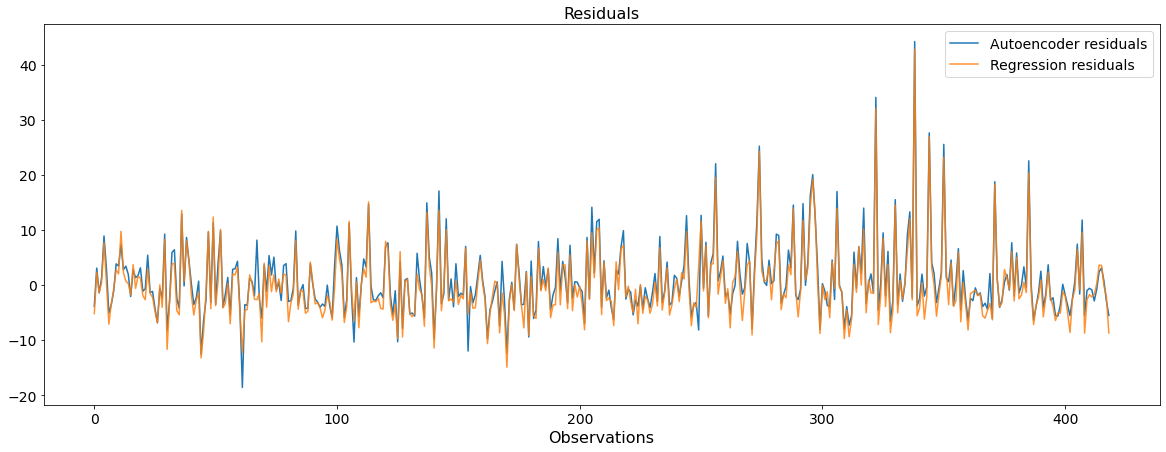

In [40]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="Autoencoder residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals", alpha=0.85)
ax.legend()
ax.set_xlabel("Observations")
plt.title("Residuals")
plt.plot()